# A3C
In this tutorial we will implement A3C (Asynchronous Advantage Actor-Critic). As the name suggests, the algorithm has three main features:
- **Actor-Critic**: It is a policy gradient based method
- **Advantage**: The baseline function is the state-value, so we have the following update rule: $$\nabla_\theta J(\theta)=\mathbf{E}_\tau[\sum_{t=0}^T\nabla_\theta\log \pi_\theta(a_t|s_t)A_t(s_t, a_t)]$$
where $$A(s_t,a_t)=E[G_t]-V(s_t)=Q(s_t,a_t)-V(s_t)$$
- **Asynchronous**: We have multiple worker networks that independently accumulate gradients and independently update these gradients to the target network.

First, we will build a Actor-Critic network using pytorch. We will then use the *torch.multiprocessing* module to spawn independent worker networks.


In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import torch.optim as optim
import numpy as np
import gym
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# One thread per process
os.environ["OMP_NUM_THREADS"] = "1"
#device = th.device('cuda') if th.cuda.is_available() else th.device('cpu')
device = th.device('cpu')

For this tutorial, we will use **CartPole** environment.

In [3]:
ENV_NAME = "CartPole-v0"
env = gym.make(ENV_NAME)
ACTION_NUM = env.action_space.n
STATE_DIM = env.observation_space.shape[0]
GAMMA = 0.9
print("No. of Actions: %d Dimensions of state %d"%(ACTION_NUM, STATE_DIM))

No. of Actions: 2 Dimensions of state 4


Now we define the actor and Value networks.
Note that advantage can be approximated as $$A(s_t,a_t)=Q(s_t,a_t)-V(s_t)= r_t + V(s_{t+1}) - V(s_t)$$.

We build the A2C network with a function to calculate the loss.

The loss for value network is $E_{t}[(r+\gamma V(s_{t+1}) - V(s_t))^2]$

The loss for actor network is $E_{t}[-\log(\pi_{\theta}(a_t|s_t))A(s_t, a_t)]$

In [4]:
def to_torch(np_array, dtype=np.float32, device=device):
    if np_array.dtype != dtype:
        np_array = np_array.astype(dtype)
    return th.from_numpy(np_array).to(device)

def set_init(layers):
    for layer in layers:
        nn.init.normal_(layer.weight, mean=0., std=0.1)
        nn.init.constant_(layer.bias, 0.)
class A2C(nn.Module):
    def __init__(self, s_dim, a_dim):
        super(A2C, self).__init__()
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.pi1 = nn.Linear(s_dim, 200)
        self.pi2 = nn.Linear(200, a_dim)
        self.v1 = nn.Linear(s_dim, 100)
        self.v2 = nn.Linear(100, 1)
        set_init([self.pi1, self.pi2, self.v1, self.v2])
        self.distribution = th.distributions.Categorical

    def forward(self, x):
        pi1 = F.relu6(self.pi1(x))
        logits = self.pi2(pi1)
        v1 = F.relu6(self.v1(x))
        values = self.v2(v1)
        return logits, values

    def choose_action(self, s):
        self.eval()
        logits, _ = self.forward(s)
        prob = F.softmax(logits, dim=1).data
        m = self.distribution(prob)
        return m.sample().cpu().numpy()[0]

    def loss_func(self, state, action, v_target):
        self.train()
        logits, values = self.forward(state)
        adv = v_target - values
        #Squared Error
        c_loss = adv.pow(2)
        
        # PG error
        probs = F.softmax(logits, dim=1)
        m = self.distribution(probs)
        exp_v = m.log_prob(action) * adv.detach().squeeze()
        a_loss = -exp_v
        total_loss = (c_loss + a_loss).mean()
        return total_loss

We modify the adam optimizer module to allow parameters to be shared to all processes.

In [5]:
class SharedAdam(th.optim.Adam):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.9), eps=1e-8,
                 weight_decay=0):
        super(SharedAdam, self).__init__(params, lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'] = 0
                state['exp_avg'] = th.zeros_like(p.data)
                state['exp_avg_sq'] = th.zeros_like(p.data)

                # share in memory to all processes
                state['exp_avg'].share_memory_()
                state['exp_avg_sq'].share_memory_()

## Hyperparameters

In [6]:
LR = 0.0001
#Number of steps till update to target network
UPDATE_FREQ = 10
MAX_EPISODES = 10000
#Number of worker networks
NUM_WORKERS = mp.cpu_count()
#NUM_WORKERS = 16

Now we intialize the target network and some global variables: rewards, number of episodes

In [7]:
target_net = A2C(STATE_DIM, ACTION_NUM).to(device)
# Share network object to all processes
target_net.share_memory()
optimizer = SharedAdam(target_net.parameters(), lr=LR)

#Global variables
total_episodes = mp.Value('i', 0)
reward_queue = mp.Queue()

Next we define a process to:
- Initialize a worker network
- Train on the environment
- Frequently do gradient update on target network and copy the new target network weights to itself.

In [8]:
class Worker(mp.Process):
    def __init__(self, target_net, opt, total_ep, result_queue, idx):
        super(Worker, self).__init__()
        self.idx = idx
        self.tot_eps, self.result_queue = total_ep, result_queue
        self.target_net, self.opt = target_net, opt
        self.worker_net = A2C(STATE_DIM, ACTION_NUM).to(device)           # local network
        self.env = gym.make(ENV_NAME)
        self.render  = False
    
    # Training routine
    def run(self):
        total_steps = 1
        total_episodes = 1
        while self.tot_eps.value < MAX_EPISODES:
            state = self.env.reset()
            
            # Stores the episode rollout (state,action,reward)
            buffer = ([], [], [])
            total_reward = 0.
            done = False
            while not done:
                if self.render:
                    self.env.render()
                
                # Select Action
                action = self.worker_net.choose_action(to_torch(state[None, :]))
        
                next_state, reward, done, _ = self.env.step(action)
                #if done: reward = -1
                total_reward += reward
                
                # Append to rollout buffer
                buffer[0].append(state)
                buffer[1].append(action)
                buffer[2].append(reward)
                
                # Asynchronous update
                if total_steps % UPDATE_FREQ == 0 or done:  # update global and assign to local net
                    # sync
                    update_params(self.opt, self.worker_net, self.target_net, done, next_state, buffer, GAMMA, device=device)
                    buffer = [[], [], []]

                    if done:
                        # store and print reward obtianed
                        
                        self.result_queue.put((total_episodes, total_reward))
                        with self.tot_eps.get_lock():
                            self.tot_eps.value += 1
                        print("Worker %2d: Episode %4d, Reward: %4d"%(self.idx, self.tot_eps.value, total_reward))
                        break
                state = next_state
                total_steps += 1
            total_episodes += 1
        self.result_queue.put(None)

## Update gradients
Not that we have to rollout the episode estimate $\{V(s_{t})\}_{t=0}^T$. Basically we estimate $V(s_t)=r_t+V(s_{t+1})$.

Then we accumulate the gradients for worker network using the estimated value functions and actions. Finally, we update the target network with the gradients.

In [9]:
def update_params(opt, worker_network, target_network, done, next_state, buffer, gamma, device=device):
    # Estimate V_()
    v_t = 0. if done else \
        worker_network.forward(to_torch(next_state[None, :]))[-1].data.cpu().numpy()[0, 0]
    
    # Calculate V(s_t)
    v_targets = []
    for reward in buffer[2][::-1]:
        v_t = reward + gamma*v_t
        v_targets.append(v_t)
    v_targets.reverse()
    v_targets = np.array(v_targets)
    
    # Calculate loss for the worker network
    worker_loss = worker_network.loss_func(state = to_torch(np.vstack(buffer[0])),
                                        action = to_torch(np.vstack(buffer[1]), dtype=np.int64), v_target=to_torch(v_targets[:, None]))
    
    #Get gradients
    opt.zero_grad()
    worker_loss.backward()
    
    # Copy gradients
    for wp, tp in zip(worker_network.parameters(), target_network.parameters()):
        tp.grad = wp.grad
    # Apply gradient
    opt.step()
    
    # Copy weights of global network to worker network
    worker_network.load_state_dict(target_network.state_dict())


## Training routine
Now we finally train!

In [10]:
worker_trainers = [Worker(target_net, optimizer, total_episodes, reward_queue, x) for x in range(NUM_WORKERS)]
worker_trainers[0].render = True
for w in worker_trainers:
    w.start()

results = pd.DataFrame(columns=['Episode', 'Reward'])

while True:
    res = reward_queue.get()
    if res is None:
        break
    else:
        results = results.append({'Episode': res[0], 'Reward': res[1]}, ignore_index=True)

for w in worker_trainers:
    w.join()


Worker  2: Episode    2, Reward:   19
Worker  1: Episode    1, Reward:   20
Worker  3: Episode    3, Reward:   21
Worker  1: Episode    4, Reward:   14
Worker  3: Episode    5, Reward:   22
Worker  2: Episode    6, Reward:   46
Worker  1: Episode    9, Reward:   26
Worker  3: Episode    8, Reward:   16
Worker  2: Episode    7, Reward:   15
Worker  3: Episode   10, Reward:   19
Worker  2: Episode   11, Reward:   24
Worker  1: Episode   12, Reward:   29
Worker  3: Episode   13, Reward:   26
Worker  1: Episode   15, Reward:   15
Worker  2: Episode   14, Reward:   38
Worker  2: Episode   16, Reward:   18
Worker  1: Episode   17, Reward:   34
Worker  2: Episode   19, Reward:   21
Worker  3: Episode   18, Reward:   32
Worker  1: Episode   20, Reward:   14
Worker  3: Episode   21, Reward:   13
Worker  1: Episode   22, Reward:   16
Worker  2: Episode   23, Reward:   27
Worker  1: Episode   24, Reward:   10
Worker  1: Episode   25, Reward:   19
Worker  3: Episode   26, Reward:   25
Worker  1: E

Worker  1: Episode  219, Reward:   28
Worker  2: Episode  218, Reward:   18
Worker  3: Episode  217, Reward:    9
Worker  1: Episode  220, Reward:   17
Worker  2: Episode  222, Reward:   20
Worker  3: Episode  221, Reward:   17
Worker  1: Episode  223, Reward:    8
Worker  2: Episode  224, Reward:   13
Worker  1: Episode  225, Reward:   14
Worker  3: Episode  226, Reward:   22
Worker  2: Episode  227, Reward:    9
Worker  0: Episode  228, Reward:   16
Worker  1: Episode  229, Reward:    9
Worker  2: Episode  230, Reward:   15
Worker  3: Episode  231, Reward:   11
Worker  2: Episode  232, Reward:   17
Worker  3: Episode  233, Reward:   22
Worker  1: Episode  234, Reward:   14
Worker  3: Episode  236, Reward:   18
Worker  2: Episode  235, Reward:   20
Worker  2: Episode  238, Reward:   17
Worker  1: Episode  237, Reward:   25
Worker  3: Episode  239, Reward:   21
Worker  1: Episode  240, Reward:   17
Worker  2: Episode  241, Reward:   15
Worker  3: Episode  242, Reward:   15
Worker  1: E

Worker  1: Episode  433, Reward:   33
Worker  3: Episode  434, Reward:   10
Worker  1: Episode  435, Reward:    9
Worker  2: Episode  436, Reward:   29
Worker  3: Episode  437, Reward:   25
Worker  1: Episode  438, Reward:   12
Worker  2: Episode  439, Reward:   11
Worker  0: Episode  441, Reward:   12
Worker  3: Episode  440, Reward:   18
Worker  3: Episode  442, Reward:   10
Worker  1: Episode  444, Reward:   20
Worker  2: Episode  443, Reward:   13
Worker  1: Episode  445, Reward:   14
Worker  2: Episode  446, Reward:    9
Worker  1: Episode  447, Reward:   10
Worker  2: Episode  448, Reward:   11
Worker  3: Episode  449, Reward:   30
Worker  3: Episode  450, Reward:   10
Worker  1: Episode  451, Reward:   15
Worker  2: Episode  452, Reward:   21
Worker  3: Episode  453, Reward:   15
Worker  2: Episode  454, Reward:   10
Worker  1: Episode  455, Reward:   12
Worker  3: Episode  456, Reward:   10
Worker  1: Episode  457, Reward:   13
Worker  3: Episode  459, Reward:    9
Worker  2: E

Worker  3: Episode  649, Reward:   11
Worker  1: Episode  650, Reward:    9
Worker  2: Episode  651, Reward:    9
Worker  3: Episode  652, Reward:   10
Worker  1: Episode  653, Reward:    9
Worker  2: Episode  654, Reward:   11
Worker  1: Episode  656, Reward:    9
Worker  2: Episode  655, Reward:   10
Worker  3: Episode  657, Reward:   28
Worker  3: Episode  658, Reward:   18
Worker  1: Episode  659, Reward:   14
Worker  3: Episode  661, Reward:   10
Worker  2: Episode  660, Reward:   21
Worker  3: Episode  664, Reward:   11
Worker  1: Episode  662, Reward:    8
Worker  2: Episode  663, Reward:    9
Worker  1: Episode  665, Reward:    9
Worker  3: Episode  666, Reward:   11
Worker  2: Episode  667, Reward:   13
Worker  1: Episode  668, Reward:    9
Worker  3: Episode  669, Reward:   10
Worker  1: Episode  670, Reward:   10
Worker  3: Episode  671, Reward:   12
Worker  2: Episode  672, Reward:   27
Worker  3: Episode  674, Reward:   15
Worker  1: Episode  673, Reward:   11
Worker  2: E

Worker  1: Episode  865, Reward:   10
Worker  2: Episode  866, Reward:   11
Worker  3: Episode  867, Reward:    9
Worker  2: Episode  868, Reward:    8
Worker  1: Episode  869, Reward:   15
Worker  2: Episode  870, Reward:   14
Worker  3: Episode  871, Reward:   28
Worker  2: Episode  872, Reward:   14
Worker  1: Episode  873, Reward:   10
Worker  3: Episode  874, Reward:   12
Worker  2: Episode  875, Reward:   13
Worker  1: Episode  876, Reward:    8
Worker  3: Episode  877, Reward:   12
Worker  1: Episode  878, Reward:    9
Worker  2: Episode  879, Reward:   15
Worker  3: Episode  881, Reward:   10
Worker  0: Episode  882, Reward:   10
Worker  1: Episode  880, Reward:   10
Worker  3: Episode  884, Reward:    9
Worker  2: Episode  883, Reward:   12
Worker  1: Episode  885, Reward:   19
Worker  3: Episode  886, Reward:    9
Worker  2: Episode  887, Reward:    9
Worker  1: Episode  888, Reward:   15
Worker  2: Episode  889, Reward:   10
Worker  3: Episode  890, Reward:   11
Worker  1: E

Worker  2: Episode 1082, Reward:    9
Worker  0: Episode 1081, Reward:    8
Worker  3: Episode 1083, Reward:   10
Worker  1: Episode 1084, Reward:   10
Worker  2: Episode 1085, Reward:   18
Worker  1: Episode 1088, Reward:   10
Worker  3: Episode 1087, Reward:   10
Worker  2: Episode 1086, Reward:    9
Worker  1: Episode 1089, Reward:    8
Worker  2: Episode 1090, Reward:    9
Worker  3: Episode 1091, Reward:   10
Worker  1: Episode 1092, Reward:   11
Worker  2: Episode 1093, Reward:    9
Worker  2: Episode 1095, Reward:   13
Worker  3: Episode 1094, Reward:    9
Worker  1: Episode 1096, Reward:   13
Worker  2: Episode 1097, Reward:    9
Worker  3: Episode 1098, Reward:   13
Worker  1: Episode 1099, Reward:   10
Worker  3: Episode 1100, Reward:    9
Worker  1: Episode 1101, Reward:   10
Worker  2: Episode 1102, Reward:    9
Worker  2: Episode 1104, Reward:    9
Worker  3: Episode 1103, Reward:   14
Worker  1: Episode 1105, Reward:    9
Worker  2: Episode 1106, Reward:   10
Worker  3: E

Worker  2: Episode 1297, Reward:   13
Worker  3: Episode 1298, Reward:   11
Worker  1: Episode 1299, Reward:   10
Worker  2: Episode 1300, Reward:    9
Worker  1: Episode 1302, Reward:   14
Worker  3: Episode 1301, Reward:   10
Worker  2: Episode 1303, Reward:   10
Worker  3: Episode 1304, Reward:   16
Worker  3: Episode 1306, Reward:   12
Worker  1: Episode 1305, Reward:   23
Worker  2: Episode 1307, Reward:   11
Worker  2: Episode 1308, Reward:   12
Worker  3: Episode 1309, Reward:   10
Worker  2: Episode 1312, Reward:    9
Worker  3: Episode 1310, Reward:   11
Worker  1: Episode 1311, Reward:    9
Worker  2: Episode 1313, Reward:    8
Worker  3: Episode 1314, Reward:   10
Worker  1: Episode 1315, Reward:    9
Worker  2: Episode 1316, Reward:   10
Worker  3: Episode 1318, Reward:   10
Worker  1: Episode 1317, Reward:   16
Worker  0: Episode 1319, Reward:   10
Worker  3: Episode 1320, Reward:    9
Worker  2: Episode 1321, Reward:   14
Worker  3: Episode 1322, Reward:    9
Worker  2: E

Worker  1: Episode 1513, Reward:    9
Worker  3: Episode 1514, Reward:   11
Worker  1: Episode 1516, Reward:   10
Worker  2: Episode 1515, Reward:    9
Worker  2: Episode 1517, Reward:    9
Worker  3: Episode 1519, Reward:   10
Worker  1: Episode 1518, Reward:   10
Worker  2: Episode 1520, Reward:   10
Worker  3: Episode 1521, Reward:    8
Worker  1: Episode 1522, Reward:    9
Worker  3: Episode 1523, Reward:    9
Worker  3: Episode 1524, Reward:   10
Worker  2: Episode 1525, Reward:   17
Worker  1: Episode 1526, Reward:    9
Worker  3: Episode 1527, Reward:   10
Worker  2: Episode 1528, Reward:    9
Worker  1: Episode 1529, Reward:   10
Worker  2: Episode 1530, Reward:   14
Worker  1: Episode 1531, Reward:   11
Worker  3: Episode 1532, Reward:    8
Worker  1: Episode 1533, Reward:    9
Worker  3: Episode 1534, Reward:    9
Worker  2: Episode 1535, Reward:   10
Worker  1: Episode 1537, Reward:   14
Worker  3: Episode 1536, Reward:   10
Worker  2: Episode 1538, Reward:   10
Worker  3: E

Worker  3: Episode 1729, Reward:   10
Worker  1: Episode 1730, Reward:   12
Worker  2: Episode 1731, Reward:   10
Worker  3: Episode 1732, Reward:   10
Worker  1: Episode 1733, Reward:   11
Worker  2: Episode 1734, Reward:   10
Worker  3: Episode 1735, Reward:   12
Worker  2: Episode 1736, Reward:    8
Worker  2: Episode 1739, Reward:   10
Worker  3: Episode 1737, Reward:    8
Worker  1: Episode 1738, Reward:   10
Worker  3: Episode 1740, Reward:    9
Worker  1: Episode 1741, Reward:    9
Worker  2: Episode 1742, Reward:   11
Worker  3: Episode 1743, Reward:   12
Worker  0: Episode 1744, Reward:    8
Worker  1: Episode 1745, Reward:    9
Worker  2: Episode 1746, Reward:    9
Worker  3: Episode 1747, Reward:   10
Worker  1: Episode 1748, Reward:    9
Worker  3: Episode 1749, Reward:    9
Worker  2: Episode 1750, Reward:    9
Worker  1: Episode 1751, Reward:   10
Worker  3: Episode 1752, Reward:    9
Worker  2: Episode 1753, Reward:   10
Worker  3: Episode 1754, Reward:    9
Worker  1: E

Worker  2: Episode 1945, Reward:    9
Worker  1: Episode 1946, Reward:   10
Worker  3: Episode 1947, Reward:   10
Worker  2: Episode 1948, Reward:    9
Worker  3: Episode 1949, Reward:    8
Worker  1: Episode 1950, Reward:    9
Worker  0: Episode 1951, Reward:    9
Worker  2: Episode 1952, Reward:    9
Worker  3: Episode 1953, Reward:   10
Worker  2: Episode 1954, Reward:    9
Worker  3: Episode 1955, Reward:   10
Worker  1: Episode 1956, Reward:    9
Worker  2: Episode 1957, Reward:   10
Worker  3: Episode 1958, Reward:    9
Worker  2: Episode 1959, Reward:    9
Worker  1: Episode 1960, Reward:    9
Worker  3: Episode 1961, Reward:   10
Worker  2: Episode 1962, Reward:    9
Worker  1: Episode 1963, Reward:   11
Worker  3: Episode 1964, Reward:    8
Worker  2: Episode 1965, Reward:    9
Worker  1: Episode 1966, Reward:    9
Worker  2: Episode 1967, Reward:    8
Worker  3: Episode 1968, Reward:   10
Worker  1: Episode 1969, Reward:    8
Worker  2: Episode 1970, Reward:   10
Worker  1: E

Worker  1: Episode 2161, Reward:    9
Worker  1: Episode 2162, Reward:    9
Worker  3: Episode 2163, Reward:   11
Worker  1: Episode 2164, Reward:   10
Worker  2: Episode 2165, Reward:   10
Worker  3: Episode 2166, Reward:    9
Worker  3: Episode 2167, Reward:    9
Worker  2: Episode 2168, Reward:    9
Worker  1: Episode 2169, Reward:    9
Worker  3: Episode 2170, Reward:   10
Worker  2: Episode 2171, Reward:    9
Worker  1: Episode 2172, Reward:   10
Worker  2: Episode 2173, Reward:    9
Worker  1: Episode 2174, Reward:   10
Worker  3: Episode 2175, Reward:   13
Worker  1: Episode 2176, Reward:    9
Worker  3: Episode 2178, Reward:   10
Worker  2: Episode 2177, Reward:    9
Worker  1: Episode 2179, Reward:   10
Worker  2: Episode 2180, Reward:   10
Worker  3: Episode 2182, Reward:    8
Worker  0: Episode 2181, Reward:    9
Worker  1: Episode 2183, Reward:    9
Worker  2: Episode 2184, Reward:    9
Worker  3: Episode 2185, Reward:    8
Worker  1: Episode 2186, Reward:    9
Worker  3: E

Worker  2: Episode 2377, Reward:   10
Worker  1: Episode 2378, Reward:    8
Worker  3: Episode 2379, Reward:   10
Worker  2: Episode 2380, Reward:    9
Worker  1: Episode 2381, Reward:   10
Worker  0: Episode 2383, Reward:    9
Worker  2: Episode 2384, Reward:    8
Worker  3: Episode 2382, Reward:    9
Worker  1: Episode 2385, Reward:    8
Worker  1: Episode 2386, Reward:   10
Worker  3: Episode 2387, Reward:   10
Worker  2: Episode 2389, Reward:   12
Worker  1: Episode 2388, Reward:   10
Worker  3: Episode 2390, Reward:    9
Worker  1: Episode 2391, Reward:    9
Worker  2: Episode 2392, Reward:    9
Worker  3: Episode 2393, Reward:   10
Worker  1: Episode 2394, Reward:   10
Worker  1: Episode 2395, Reward:    9
Worker  3: Episode 2396, Reward:    9
Worker  2: Episode 2397, Reward:   10
Worker  1: Episode 2398, Reward:    9
Worker  3: Episode 2399, Reward:   10
Worker  1: Episode 2401, Reward:   10
Worker  2: Episode 2400, Reward:   10
Worker  3: Episode 2402, Reward:    9
Worker  2: E

Worker  3: Episode 2593, Reward:    9
Worker  1: Episode 2594, Reward:   10
Worker  2: Episode 2595, Reward:    8
Worker  3: Episode 2596, Reward:    9
Worker  1: Episode 2597, Reward:    9
Worker  3: Episode 2599, Reward:   11
Worker  2: Episode 2598, Reward:   10
Worker  1: Episode 2600, Reward:   13
Worker  2: Episode 2602, Reward:    9
Worker  3: Episode 2603, Reward:   10
Worker  0: Episode 2601, Reward:   10
Worker  2: Episode 2604, Reward:    9
Worker  2: Episode 2606, Reward:    9
Worker  1: Episode 2605, Reward:    9
Worker  3: Episode 2607, Reward:   10
Worker  2: Episode 2608, Reward:   10
Worker  3: Episode 2609, Reward:    8
Worker  1: Episode 2610, Reward:    8
Worker  2: Episode 2611, Reward:   12
Worker  3: Episode 2612, Reward:   10
Worker  1: Episode 2613, Reward:    9
Worker  2: Episode 2614, Reward:   10
Worker  3: Episode 2615, Reward:    9
Worker  1: Episode 2616, Reward:   10
Worker  3: Episode 2617, Reward:   10
Worker  1: Episode 2619, Reward:    9
Worker  3: E

Worker  1: Episode 2809, Reward:   10
Worker  3: Episode 2810, Reward:   10
Worker  2: Episode 2812, Reward:   10
Worker  1: Episode 2811, Reward:   10
Worker  2: Episode 2813, Reward:   10
Worker  1: Episode 2814, Reward:    9
Worker  3: Episode 2815, Reward:    9
Worker  2: Episode 2816, Reward:    9
Worker  1: Episode 2817, Reward:    8
Worker  3: Episode 2818, Reward:    8
Worker  3: Episode 2819, Reward:    9
Worker  2: Episode 2820, Reward:   10
Worker  1: Episode 2821, Reward:   10
Worker  2: Episode 2822, Reward:   10
Worker  3: Episode 2823, Reward:   11
Worker  1: Episode 2824, Reward:    8
Worker  2: Episode 2825, Reward:    9
Worker  1: Episode 2826, Reward:    9
Worker  3: Episode 2827, Reward:    9
Worker  2: Episode 2828, Reward:   10
Worker  3: Episode 2829, Reward:   10
Worker  1: Episode 2830, Reward:    9
Worker  3: Episode 2831, Reward:   10
Worker  1: Episode 2832, Reward:   13
Worker  2: Episode 2833, Reward:   10
Worker  3: Episode 2834, Reward:    9
Worker  3: E

Worker  2: Episode 3024, Reward:   10
Worker  1: Episode 3026, Reward:   10
Worker  3: Episode 3027, Reward:   13
Worker  2: Episode 3029, Reward:   14
Worker  1: Episode 3028, Reward:    9
Worker  3: Episode 3030, Reward:    8
Worker  1: Episode 3031, Reward:    8
Worker  2: Episode 3032, Reward:   10
Worker  3: Episode 3034, Reward:   10
Worker  1: Episode 3033, Reward:   10
Worker  2: Episode 3035, Reward:    9
Worker  3: Episode 3036, Reward:   11
Worker  2: Episode 3039, Reward:   10
Worker  1: Episode 3037, Reward:   10
Worker  3: Episode 3038, Reward:   10
Worker  2: Episode 3041, Reward:   12
Worker  3: Episode 3040, Reward:   11
Worker  1: Episode 3042, Reward:    9
Worker  2: Episode 3043, Reward:   10
Worker  1: Episode 3044, Reward:   10
Worker  3: Episode 3045, Reward:   12
Worker  2: Episode 3046, Reward:   10
Worker  1: Episode 3048, Reward:    9
Worker  0: Episode 3048, Reward:    9
Worker  1: Episode 3049, Reward:   10
Worker  2: Episode 3050, Reward:   10
Worker  3: E

Worker  2: Episode 3241, Reward:   10
Worker  1: Episode 3242, Reward:    9
Worker  3: Episode 3243, Reward:   10
Worker  2: Episode 3244, Reward:   12
Worker  1: Episode 3245, Reward:    9
Worker  3: Episode 3246, Reward:   10
Worker  1: Episode 3247, Reward:   10
Worker  2: Episode 3248, Reward:   11
Worker  1: Episode 3249, Reward:   14
Worker  3: Episode 3250, Reward:   10
Worker  2: Episode 3251, Reward:    9
Worker  3: Episode 3253, Reward:   10
Worker  1: Episode 3252, Reward:   10
Worker  3: Episode 3255, Reward:   10
Worker  2: Episode 3254, Reward:    8
Worker  1: Episode 3256, Reward:    9
Worker  3: Episode 3257, Reward:   12
Worker  2: Episode 3258, Reward:   10
Worker  0: Episode 3259, Reward:   10
Worker  1: Episode 3260, Reward:    9
Worker  3: Episode 3261, Reward:   13
Worker  2: Episode 3262, Reward:    8
Worker  1: Episode 3263, Reward:   11
Worker  3: Episode 3264, Reward:    9
Worker  2: Episode 3265, Reward:   10
Worker  3: Episode 3266, Reward:   10
Worker  1: E

Worker  3: Episode 3457, Reward:   10
Worker  1: Episode 3458, Reward:   16
Worker  3: Episode 3459, Reward:    9
Worker  2: Episode 3460, Reward:   14
Worker  3: Episode 3462, Reward:    9
Worker  1: Episode 3461, Reward:   10
Worker  2: Episode 3463, Reward:    9
Worker  3: Episode 3464, Reward:   10
Worker  1: Episode 3465, Reward:    9
Worker  2: Episode 3466, Reward:   15
Worker  3: Episode 3467, Reward:   11
Worker  1: Episode 3468, Reward:   11
Worker  2: Episode 3470, Reward:   11
Worker  3: Episode 3469, Reward:    8
Worker  3: Episode 3471, Reward:    9
Worker  1: Episode 3472, Reward:   10
Worker  3: Episode 3473, Reward:   10
Worker  2: Episode 3474, Reward:   17
Worker  1: Episode 3475, Reward:    9
Worker  3: Episode 3476, Reward:    9
Worker  1: Episode 3477, Reward:   14
Worker  3: Episode 3478, Reward:   10
Worker  2: Episode 3479, Reward:   14
Worker  1: Episode 3480, Reward:   15
Worker  2: Episode 3482, Reward:    9
Worker  3: Episode 3481, Reward:   13
Worker  1: E

Worker  1: Episode 3672, Reward:   10
Worker  3: Episode 3674, Reward:   13
Worker  0: Episode 3676, Reward:   12
Worker  2: Episode 3675, Reward:    9
Worker  1: Episode 3677, Reward:    8
Worker  1: Episode 3679, Reward:    9
Worker  3: Episode 3678, Reward:    9
Worker  2: Episode 3680, Reward:   12
Worker  2: Episode 3682, Reward:   12
Worker  1: Episode 3681, Reward:   18
Worker  3: Episode 3683, Reward:   26
Worker  2: Episode 3684, Reward:    9
Worker  1: Episode 3686, Reward:   16
Worker  3: Episode 3685, Reward:   22
Worker  2: Episode 3687, Reward:   10
Worker  2: Episode 3688, Reward:   10
Worker  3: Episode 3689, Reward:   12
Worker  3: Episode 3691, Reward:   11
Worker  1: Episode 3690, Reward:   18
Worker  2: Episode 3692, Reward:   15
Worker  1: Episode 3693, Reward:   12
Worker  3: Episode 3694, Reward:   13
Worker  2: Episode 3696, Reward:   14
Worker  1: Episode 3697, Reward:   10
Worker  3: Episode 3695, Reward:    9
Worker  1: Episode 3698, Reward:   10
Worker  3: E

Worker  2: Episode 3889, Reward:   33
Worker  3: Episode 3890, Reward:   13
Worker  1: Episode 3891, Reward:   13
Worker  2: Episode 3893, Reward:   16
Worker  0: Episode 3892, Reward:   12
Worker  3: Episode 3894, Reward:   12
Worker  1: Episode 3895, Reward:    9
Worker  3: Episode 3896, Reward:   15
Worker  1: Episode 3897, Reward:   12
Worker  2: Episode 3898, Reward:   19
Worker  3: Episode 3899, Reward:    9
Worker  1: Episode 3900, Reward:   10
Worker  2: Episode 3901, Reward:   11
Worker  1: Episode 3902, Reward:    8
Worker  3: Episode 3903, Reward:    9
Worker  2: Episode 3904, Reward:   14
Worker  1: Episode 3905, Reward:   15
Worker  2: Episode 3906, Reward:    9
Worker  3: Episode 3907, Reward:   12
Worker  1: Episode 3908, Reward:    9
Worker  2: Episode 3910, Reward:   10
Worker  3: Episode 3909, Reward:   10
Worker  3: Episode 3911, Reward:    9
Worker  1: Episode 3913, Reward:   18
Worker  2: Episode 3912, Reward:   13
Worker  3: Episode 3914, Reward:   18
Worker  1: E

Worker  1: Episode 4104, Reward:   17
Worker  3: Episode 4107, Reward:   15
Worker  2: Episode 4106, Reward:   11
Worker  2: Episode 4108, Reward:   13
Worker  3: Episode 4109, Reward:   14
Worker  1: Episode 4110, Reward:   20
Worker  1: Episode 4111, Reward:   13
Worker  3: Episode 4112, Reward:   14
Worker  2: Episode 4113, Reward:   14
Worker  1: Episode 4114, Reward:   11
Worker  2: Episode 4115, Reward:   14
Worker  3: Episode 4116, Reward:   27
Worker  1: Episode 4117, Reward:   11
Worker  2: Episode 4118, Reward:   14
Worker  3: Episode 4119, Reward:   13
Worker  1: Episode 4120, Reward:   18
Worker  3: Episode 4121, Reward:   11
Worker  2: Episode 4122, Reward:   22
Worker  1: Episode 4123, Reward:   17
Worker  3: Episode 4124, Reward:   14
Worker  2: Episode 4125, Reward:   10
Worker  1: Episode 4126, Reward:    9
Worker  2: Episode 4127, Reward:   13
Worker  1: Episode 4128, Reward:   12
Worker  3: Episode 4129, Reward:   38
Worker  1: Episode 4130, Reward:   17
Worker  2: E

Worker  1: Episode 4321, Reward:   15
Worker  3: Episode 4323, Reward:   45
Worker  2: Episode 4322, Reward:   10
Worker  1: Episode 4324, Reward:   12
Worker  3: Episode 4325, Reward:   10
Worker  2: Episode 4326, Reward:   19
Worker  1: Episode 4327, Reward:   25
Worker  3: Episode 4328, Reward:   19
Worker  2: Episode 4329, Reward:   29
Worker  1: Episode 4330, Reward:   30
Worker  3: Episode 4331, Reward:   20
Worker  2: Episode 4332, Reward:   32
Worker  1: Episode 4333, Reward:   15
Worker  3: Episode 4334, Reward:   24
Worker  3: Episode 4335, Reward:   13
Worker  2: Episode 4336, Reward:   31
Worker  1: Episode 4337, Reward:   32
Worker  3: Episode 4339, Reward:   15
Worker  2: Episode 4338, Reward:   14
Worker  1: Episode 4340, Reward:   11
Worker  2: Episode 4341, Reward:   11
Worker  1: Episode 4342, Reward:   18
Worker  2: Episode 4343, Reward:   23
Worker  3: Episode 4344, Reward:   43
Worker  1: Episode 4345, Reward:   13
Worker  3: Episode 4346, Reward:   12
Worker  2: E

Worker  1: Episode 4537, Reward:   15
Worker  3: Episode 4538, Reward:   23
Worker  2: Episode 4539, Reward:   60
Worker  3: Episode 4540, Reward:   21
Worker  1: Episode 4541, Reward:   44
Worker  3: Episode 4542, Reward:   21
Worker  0: Episode 4543, Reward:   35
Worker  2: Episode 4544, Reward:   68
Worker  3: Episode 4545, Reward:   28
Worker  3: Episode 4546, Reward:   23
Worker  1: Episode 4547, Reward:   79
Worker  1: Episode 4549, Reward:   23
Worker  3: Episode 4550, Reward:   37
Worker  2: Episode 4548, Reward:   71
Worker  2: Episode 4551, Reward:   19
Worker  1: Episode 4552, Reward:   16
Worker  1: Episode 4553, Reward:   14
Worker  3: Episode 4554, Reward:   38
Worker  2: Episode 4555, Reward:   14
Worker  1: Episode 4556, Reward:   15
Worker  3: Episode 4557, Reward:   13
Worker  1: Episode 4558, Reward:   12
Worker  3: Episode 4559, Reward:   17
Worker  1: Episode 4560, Reward:   15
Worker  2: Episode 4561, Reward:   37
Worker  2: Episode 4562, Reward:   11
Worker  2: E

Worker  3: Episode 4753, Reward:   79
Worker  2: Episode 4754, Reward:   52
Worker  1: Episode 4755, Reward:   28
Worker  3: Episode 4756, Reward:   17
Worker  2: Episode 4757, Reward:   18
Worker  1: Episode 4758, Reward:   31
Worker  3: Episode 4759, Reward:   34
Worker  1: Episode 4760, Reward:   27
Worker  2: Episode 4761, Reward:   38
Worker  1: Episode 4762, Reward:   16
Worker  3: Episode 4763, Reward:   28
Worker  2: Episode 4764, Reward:   18
Worker  1: Episode 4765, Reward:   32
Worker  3: Episode 4766, Reward:   21
Worker  3: Episode 4767, Reward:   16
Worker  2: Episode 4768, Reward:   22
Worker  1: Episode 4770, Reward:   38
Worker  2: Episode 4769, Reward:   15
Worker  1: Episode 4771, Reward:   12
Worker  1: Episode 4772, Reward:   39
Worker  3: Episode 4773, Reward:   86
Worker  2: Episode 4774, Reward:   87
Worker  3: Episode 4775, Reward:   47
Worker  2: Episode 4776, Reward:   12
Worker  3: Episode 4777, Reward:   13
Worker  1: Episode 4778, Reward:   61
Worker  2: E

Worker  1: Episode 4969, Reward:  132
Worker  2: Episode 4970, Reward:   72
Worker  3: Episode 4971, Reward:  104
Worker  3: Episode 4972, Reward:   14
Worker  1: Episode 4973, Reward:   87
Worker  2: Episode 4974, Reward:   56
Worker  3: Episode 4975, Reward:   61
Worker  1: Episode 4976, Reward:   45
Worker  1: Episode 4977, Reward:   18
Worker  2: Episode 4978, Reward:   58
Worker  3: Episode 4979, Reward:   29
Worker  1: Episode 4980, Reward:   48
Worker  2: Episode 4981, Reward:   44
Worker  3: Episode 4982, Reward:   78
Worker  1: Episode 4983, Reward:   30
Worker  1: Episode 4984, Reward:   39
Worker  2: Episode 4985, Reward:   88
Worker  1: Episode 4986, Reward:   26
Worker  3: Episode 4987, Reward:   98
Worker  1: Episode 4988, Reward:   57
Worker  2: Episode 4989, Reward:   94
Worker  3: Episode 4990, Reward:   70
Worker  1: Episode 4991, Reward:   73
Worker  3: Episode 4992, Reward:   58
Worker  3: Episode 4993, Reward:   58
Worker  1: Episode 4994, Reward:   90
Worker  2: E

Worker  1: Episode 5185, Reward:   40
Worker  3: Episode 5186, Reward:  174
Worker  3: Episode 5187, Reward:   43
Worker  2: Episode 5188, Reward:   78
Worker  1: Episode 5189, Reward:  100
Worker  3: Episode 5190, Reward:   52
Worker  1: Episode 5191, Reward:   72
Worker  2: Episode 5192, Reward:  122
Worker  3: Episode 5193, Reward:  101
Worker  1: Episode 5195, Reward:   65
Worker  2: Episode 5194, Reward:   49
Worker  1: Episode 5196, Reward:   43
Worker  3: Episode 5197, Reward:   67
Worker  1: Episode 5198, Reward:   15
Worker  2: Episode 5199, Reward:   82
Worker  3: Episode 5200, Reward:   63
Worker  0: Episode 5201, Reward:   50
Worker  3: Episode 5202, Reward:   38
Worker  1: Episode 5203, Reward:   86
Worker  2: Episode 5204, Reward:   89
Worker  1: Episode 5205, Reward:   51
Worker  3: Episode 5206, Reward:  102
Worker  2: Episode 5207, Reward:   52
Worker  1: Episode 5208, Reward:   61
Worker  3: Episode 5209, Reward:   61
Worker  2: Episode 5210, Reward:   47
Worker  1: E

Worker  2: Episode 5401, Reward:   93
Worker  1: Episode 5402, Reward:   98
Worker  3: Episode 5403, Reward:   84
Worker  1: Episode 5404, Reward:   43
Worker  2: Episode 5405, Reward:   57
Worker  1: Episode 5406, Reward:   99
Worker  2: Episode 5407, Reward:   85
Worker  3: Episode 5408, Reward:  120
Worker  2: Episode 5409, Reward:   50
Worker  1: Episode 5410, Reward:   71
Worker  3: Episode 5411, Reward:   90
Worker  1: Episode 5412, Reward:   44
Worker  2: Episode 5413, Reward:   71
Worker  3: Episode 5414, Reward:   42
Worker  1: Episode 5415, Reward:   38
Worker  2: Episode 5416, Reward:   30
Worker  1: Episode 5417, Reward:   28
Worker  3: Episode 5418, Reward:   64
Worker  2: Episode 5420, Reward:   75
Worker  3: Episode 5419, Reward:   58
Worker  1: Episode 5421, Reward:   72
Worker  2: Episode 5422, Reward:   38
Worker  1: Episode 5423, Reward:   39
Worker  3: Episode 5424, Reward:   76
Worker  1: Episode 5425, Reward:   21
Worker  2: Episode 5426, Reward:   66
Worker  3: E

Worker  2: Episode 5617, Reward:   62
Worker  1: Episode 5618, Reward:   56
Worker  1: Episode 5619, Reward:   65
Worker  3: Episode 5621, Reward:   81
Worker  2: Episode 5620, Reward:   70
Worker  3: Episode 5622, Reward:   46
Worker  2: Episode 5623, Reward:   47
Worker  3: Episode 5624, Reward:   32
Worker  1: Episode 5625, Reward:  102
Worker  2: Episode 5626, Reward:   43
Worker  3: Episode 5627, Reward:   69
Worker  1: Episode 5628, Reward:  123
Worker  2: Episode 5629, Reward:  117
Worker  1: Episode 5630, Reward:   30
Worker  3: Episode 5631, Reward:  113
Worker  1: Episode 5632, Reward:   42
Worker  3: Episode 5633, Reward:  118
Worker  2: Episode 5634, Reward:  200
Worker  1: Episode 5635, Reward:  135
Worker  3: Episode 5636, Reward:   61
Worker  2: Episode 5637, Reward:   58
Worker  1: Episode 5638, Reward:  116
Worker  3: Episode 5639, Reward:   68
Worker  2: Episode 5640, Reward:  121
Worker  1: Episode 5641, Reward:   70
Worker  3: Episode 5642, Reward:  102
Worker  2: E

Worker  1: Episode 5832, Reward:   51
Worker  2: Episode 5834, Reward:   83
Worker  1: Episode 5835, Reward:   84
Worker  3: Episode 5836, Reward:  196
Worker  2: Episode 5837, Reward:   93
Worker  3: Episode 5838, Reward:   89
Worker  1: Episode 5839, Reward:  113
Worker  2: Episode 5841, Reward:  100
Worker  1: Episode 5840, Reward:   65
Worker  1: Episode 5843, Reward:   27
Worker  3: Episode 5842, Reward:   94
Worker  2: Episode 5844, Reward:   64
Worker  0: Episode 5845, Reward:   79
Worker  2: Episode 5846, Reward:   39
Worker  3: Episode 5847, Reward:   62
Worker  1: Episode 5848, Reward:   74
Worker  2: Episode 5849, Reward:   47
Worker  1: Episode 5850, Reward:   59
Worker  3: Episode 5851, Reward:   98
Worker  2: Episode 5852, Reward:   61
Worker  1: Episode 5853, Reward:   31
Worker  2: Episode 5854, Reward:   82
Worker  3: Episode 5855, Reward:  112
Worker  1: Episode 5856, Reward:  146
Worker  3: Episode 5857, Reward:   92
Worker  2: Episode 5858, Reward:  110
Worker  1: E

Worker  1: Episode 6049, Reward:   53
Worker  3: Episode 6050, Reward:   45
Worker  2: Episode 6051, Reward:   61
Worker  1: Episode 6052, Reward:   64
Worker  2: Episode 6053, Reward:   58
Worker  3: Episode 6054, Reward:   69
Worker  0: Episode 6055, Reward:   94
Worker  2: Episode 6056, Reward:  127
Worker  1: Episode 6057, Reward:  149
Worker  3: Episode 6058, Reward:  134
Worker  2: Episode 6059, Reward:   62
Worker  3: Episode 6060, Reward:   63
Worker  1: Episode 6061, Reward:  151
Worker  3: Episode 6062, Reward:   70
Worker  2: Episode 6063, Reward:  127
Worker  1: Episode 6064, Reward:   91
Worker  3: Episode 6065, Reward:   89
Worker  1: Episode 6066, Reward:   57
Worker  3: Episode 6067, Reward:   77
Worker  2: Episode 6068, Reward:  153
Worker  3: Episode 6069, Reward:   49
Worker  1: Episode 6070, Reward:   90
Worker  2: Episode 6071, Reward:   74
Worker  2: Episode 6072, Reward:   91
Worker  1: Episode 6073, Reward:  135
Worker  3: Episode 6074, Reward:  148
Worker  2: E

Worker  3: Episode 6266, Reward:   66
Worker  2: Episode 6265, Reward:   25
Worker  1: Episode 6267, Reward:   67
Worker  2: Episode 6268, Reward:   91
Worker  3: Episode 6269, Reward:   88
Worker  1: Episode 6270, Reward:   83
Worker  3: Episode 6271, Reward:   52
Worker  2: Episode 6272, Reward:   70
Worker  1: Episode 6273, Reward:   38
Worker  3: Episode 6274, Reward:   68
Worker  2: Episode 6275, Reward:   92
Worker  1: Episode 6276, Reward:  145
Worker  2: Episode 6277, Reward:   75
Worker  1: Episode 6278, Reward:   99
Worker  3: Episode 6279, Reward:  192
Worker  1: Episode 6280, Reward:   37
Worker  3: Episode 6281, Reward:   54
Worker  2: Episode 6282, Reward:  150
Worker  1: Episode 6283, Reward:  115
Worker  2: Episode 6284, Reward:   74
Worker  3: Episode 6285, Reward:  127
Worker  2: Episode 6286, Reward:   40
Worker  1: Episode 6287, Reward:   76
Worker  1: Episode 6288, Reward:   22
Worker  3: Episode 6289, Reward:   83
Worker  2: Episode 6290, Reward:   95
Worker  1: E

Worker  2: Episode 6481, Reward:   21
Worker  1: Episode 6482, Reward:   66
Worker  2: Episode 6483, Reward:   27
Worker  3: Episode 6484, Reward:   78
Worker  1: Episode 6485, Reward:   51
Worker  2: Episode 6486, Reward:   60
Worker  3: Episode 6487, Reward:   56
Worker  1: Episode 6488, Reward:   71
Worker  3: Episode 6489, Reward:   56
Worker  2: Episode 6490, Reward:   62
Worker  1: Episode 6491, Reward:   29
Worker  1: Episode 6492, Reward:   52
Worker  2: Episode 6493, Reward:   56
Worker  3: Episode 6494, Reward:   98
Worker  3: Episode 6496, Reward:   53
Worker  1: Episode 6495, Reward:   64
Worker  2: Episode 6497, Reward:   96
Worker  3: Episode 6498, Reward:   39
Worker  3: Episode 6499, Reward:   19
Worker  2: Episode 6500, Reward:   24
Worker  1: Episode 6501, Reward:   80
Worker  2: Episode 6502, Reward:   55
Worker  0: Episode 6503, Reward:   39
Worker  3: Episode 6504, Reward:  106
Worker  2: Episode 6505, Reward:   58
Worker  2: Episode 6506, Reward:   62
Worker  3: E

Worker  3: Episode 6697, Reward:   70
Worker  2: Episode 6698, Reward:   44
Worker  3: Episode 6699, Reward:   30
Worker  1: Episode 6700, Reward:   60
Worker  2: Episode 6701, Reward:   62
Worker  1: Episode 6702, Reward:   65
Worker  3: Episode 6703, Reward:   74
Worker  2: Episode 6704, Reward:   73
Worker  3: Episode 6705, Reward:   78
Worker  1: Episode 6706, Reward:  102
Worker  3: Episode 6707, Reward:   59
Worker  2: Episode 6708, Reward:   95
Worker  1: Episode 6709, Reward:   67
Worker  3: Episode 6710, Reward:   48
Worker  1: Episode 6711, Reward:   52
Worker  2: Episode 6712, Reward:   68
Worker  2: Episode 6713, Reward:   15
Worker  3: Episode 6714, Reward:   82
Worker  1: Episode 6715, Reward:   85
Worker  3: Episode 6716, Reward:   93
Worker  2: Episode 6717, Reward:  121
Worker  1: Episode 6718, Reward:   69
Worker  3: Episode 6719, Reward:   28
Worker  2: Episode 6720, Reward:   66
Worker  3: Episode 6721, Reward:   70
Worker  1: Episode 6722, Reward:  100
Worker  2: E

Worker  3: Episode 6913, Reward:   53
Worker  2: Episode 6914, Reward:   13
Worker  1: Episode 6915, Reward:   15
Worker  3: Episode 6916, Reward:   67
Worker  1: Episode 6917, Reward:   78
Worker  2: Episode 6918, Reward:   89
Worker  1: Episode 6919, Reward:   85
Worker  2: Episode 6920, Reward:   78
Worker  3: Episode 6921, Reward:   92
Worker  2: Episode 6922, Reward:   52
Worker  1: Episode 6923, Reward:   83
Worker  3: Episode 6924, Reward:   59
Worker  2: Episode 6925, Reward:   57
Worker  3: Episode 6926, Reward:   54
Worker  1: Episode 6927, Reward:   66
Worker  1: Episode 6928, Reward:   54
Worker  3: Episode 6929, Reward:   84
Worker  2: Episode 6930, Reward:  119
Worker  3: Episode 6931, Reward:   40
Worker  1: Episode 6932, Reward:   83
Worker  2: Episode 6933, Reward:   81
Worker  3: Episode 6934, Reward:   80
Worker  1: Episode 6935, Reward:   68
Worker  2: Episode 6936, Reward:   41
Worker  3: Episode 6937, Reward:   86
Worker  1: Episode 6938, Reward:  103
Worker  3: E

Worker  1: Episode 7129, Reward:   63
Worker  2: Episode 7130, Reward:   68
Worker  1: Episode 7131, Reward:   35
Worker  3: Episode 7132, Reward:   46
Worker  2: Episode 7133, Reward:   64
Worker  1: Episode 7135, Reward:   63
Worker  3: Episode 7134, Reward:   62
Worker  2: Episode 7136, Reward:   58
Worker  1: Episode 7137, Reward:   45
Worker  3: Episode 7138, Reward:   63
Worker  3: Episode 7139, Reward:   22
Worker  2: Episode 7140, Reward:   66
Worker  1: Episode 7141, Reward:   68
Worker  2: Episode 7143, Reward:   63
Worker  3: Episode 7142, Reward:   86
Worker  1: Episode 7144, Reward:   78
Worker  3: Episode 7145, Reward:   67
Worker  2: Episode 7146, Reward:   85
Worker  3: Episode 7147, Reward:    9
Worker  1: Episode 7148, Reward:   83
Worker  2: Episode 7149, Reward:   26
Worker  3: Episode 7150, Reward:   48
Worker  1: Episode 7151, Reward:   56
Worker  2: Episode 7152, Reward:   67
Worker  3: Episode 7153, Reward:   62
Worker  1: Episode 7154, Reward:   90
Worker  2: E

Worker  2: Episode 7345, Reward:   49
Worker  1: Episode 7346, Reward:   40
Worker  3: Episode 7347, Reward:   62
Worker  2: Episode 7348, Reward:   61
Worker  3: Episode 7350, Reward:   28
Worker  1: Episode 7349, Reward:   69
Worker  3: Episode 7351, Reward:   16
Worker  1: Episode 7352, Reward:   17
Worker  2: Episode 7353, Reward:   64
Worker  2: Episode 7354, Reward:   10
Worker  3: Episode 7355, Reward:   38
Worker  1: Episode 7356, Reward:   24
Worker  3: Episode 7357, Reward:   15
Worker  1: Episode 7358, Reward:   27
Worker  2: Episode 7359, Reward:   30
Worker  2: Episode 7360, Reward:   14
Worker  3: Episode 7361, Reward:   33
Worker  1: Episode 7362, Reward:   49
Worker  2: Episode 7363, Reward:   76
Worker  1: Episode 7364, Reward:   69
Worker  3: Episode 7366, Reward:  111
Worker  2: Episode 7365, Reward:   50
Worker  1: Episode 7367, Reward:   33
Worker  3: Episode 7368, Reward:   39
Worker  2: Episode 7369, Reward:   72
Worker  3: Episode 7370, Reward:   48
Worker  1: E

Worker  1: Episode 7561, Reward:   70
Worker  2: Episode 7562, Reward:   71
Worker  3: Episode 7563, Reward:   59
Worker  2: Episode 7564, Reward:   19
Worker  1: Episode 7565, Reward:   31
Worker  3: Episode 7566, Reward:   46
Worker  2: Episode 7567, Reward:   49
Worker  1: Episode 7568, Reward:   58
Worker  2: Episode 7569, Reward:   16
Worker  3: Episode 7570, Reward:   65
Worker  2: Episode 7571, Reward:   35
Worker  1: Episode 7572, Reward:   56
Worker  1: Episode 7573, Reward:   45
Worker  2: Episode 7575, Reward:   70
Worker  3: Episode 7574, Reward:   90
Worker  3: Episode 7576, Reward:   16
Worker  1: Episode 7577, Reward:   58
Worker  3: Episode 7578, Reward:   36
Worker  2: Episode 7579, Reward:   65
Worker  3: Episode 7580, Reward:   44
Worker  1: Episode 7581, Reward:   69
Worker  3: Episode 7582, Reward:   21
Worker  2: Episode 7583, Reward:   75
Worker  3: Episode 7584, Reward:   25
Worker  1: Episode 7585, Reward:   77
Worker  2: Episode 7586, Reward:   67
Worker  3: E

Worker  1: Episode 7777, Reward:   73
Worker  3: Episode 7778, Reward:   54
Worker  0: Episode 7779, Reward:   70
Worker  1: Episode 7780, Reward:   57
Worker  3: Episode 7781, Reward:   50
Worker  2: Episode 7782, Reward:   76
Worker  1: Episode 7783, Reward:   13
Worker  2: Episode 7784, Reward:   16
Worker  3: Episode 7785, Reward:   26
Worker  2: Episode 7787, Reward:   16
Worker  1: Episode 7786, Reward:   16
Worker  1: Episode 7788, Reward:   18
Worker  3: Episode 7790, Reward:   46
Worker  2: Episode 7789, Reward:   50
Worker  2: Episode 7791, Reward:   17
Worker  1: Episode 7792, Reward:   49
Worker  3: Episode 7793, Reward:   66
Worker  2: Episode 7794, Reward:   48
Worker  2: Episode 7795, Reward:   25
Worker  3: Episode 7796, Reward:   62
Worker  1: Episode 7797, Reward:   64
Worker  2: Episode 7798, Reward:   13
Worker  1: Episode 7799, Reward:   20
Worker  1: Episode 7800, Reward:   15
Worker  3: Episode 7801, Reward:   76
Worker  2: Episode 7802, Reward:   62
Worker  1: E

Worker  3: Episode 7993, Reward:   15
Worker  1: Episode 7994, Reward:   57
Worker  2: Episode 7995, Reward:   69
Worker  3: Episode 7996, Reward:   62
Worker  2: Episode 7998, Reward:   48
Worker  1: Episode 7997, Reward:   64
Worker  3: Episode 7999, Reward:   55
Worker  1: Episode 8001, Reward:   51
Worker  2: Episode 8000, Reward:   48
Worker  3: Episode 8002, Reward:   80
Worker  2: Episode 8003, Reward:   68
Worker  1: Episode 8004, Reward:   87
Worker  3: Episode 8005, Reward:   38
Worker  2: Episode 8006, Reward:   55
Worker  3: Episode 8007, Reward:   70
Worker  1: Episode 8008, Reward:   69
Worker  1: Episode 8009, Reward:   22
Worker  2: Episode 8010, Reward:   67
Worker  3: Episode 8011, Reward:   46
Worker  3: Episode 8012, Reward:   44
Worker  1: Episode 8013, Reward:   59
Worker  2: Episode 8014, Reward:   71
Worker  2: Episode 8015, Reward:   24
Worker  1: Episode 8017, Reward:   63
Worker  3: Episode 8016, Reward:   66
Worker  2: Episode 8018, Reward:   65
Worker  3: E

Worker  2: Episode 8209, Reward:   87
Worker  1: Episode 8210, Reward:   65
Worker  3: Episode 8211, Reward:   59
Worker  2: Episode 8212, Reward:   62
Worker  1: Episode 8213, Reward:   69
Worker  2: Episode 8214, Reward:   65
Worker  3: Episode 8215, Reward:   91
Worker  1: Episode 8216, Reward:   51
Worker  2: Episode 8217, Reward:   72
Worker  3: Episode 8218, Reward:   60
Worker  1: Episode 8219, Reward:   62
Worker  2: Episode 8220, Reward:   52
Worker  1: Episode 8222, Reward:   39
Worker  3: Episode 8221, Reward:   63
Worker  2: Episode 8223, Reward:   39
Worker  3: Episode 8224, Reward:   21
Worker  1: Episode 8225, Reward:   57
Worker  3: Episode 8226, Reward:   54
Worker  2: Episode 8227, Reward:   54
Worker  2: Episode 8228, Reward:   13
Worker  1: Episode 8229, Reward:   59
Worker  3: Episode 8230, Reward:   87
Worker  2: Episode 8231, Reward:   66
Worker  1: Episode 8232, Reward:   68
Worker  3: Episode 8233, Reward:   40
Worker  1: Episode 8234, Reward:   42
Worker  2: E

Worker  1: Episode 8425, Reward:   63
Worker  3: Episode 8427, Reward:   44
Worker  2: Episode 8426, Reward:   46
Worker  1: Episode 8428, Reward:   45
Worker  3: Episode 8429, Reward:   59
Worker  2: Episode 8430, Reward:   51
Worker  1: Episode 8431, Reward:   55
Worker  3: Episode 8432, Reward:   16
Worker  1: Episode 8433, Reward:   17
Worker  1: Episode 8434, Reward:   12
Worker  2: Episode 8435, Reward:   60
Worker  3: Episode 8436, Reward:   79
Worker  1: Episode 8437, Reward:   44
Worker  2: Episode 8438, Reward:   60
Worker  3: Episode 8439, Reward:   14
Worker  2: Episode 8440, Reward:   16
Worker  1: Episode 8441, Reward:   50
Worker  3: Episode 8442, Reward:   43
Worker  2: Episode 8443, Reward:   63
Worker  1: Episode 8444, Reward:   60
Worker  3: Episode 8446, Reward:   61
Worker  2: Episode 8447, Reward:   36
Worker  0: Episode 8445, Reward:   57
Worker  1: Episode 8448, Reward:   55
Worker  3: Episode 8449, Reward:   61
Worker  2: Episode 8450, Reward:   63
Worker  1: E

Worker  1: Episode 8641, Reward:   39
Worker  2: Episode 8642, Reward:   37
Worker  2: Episode 8643, Reward:   40
Worker  3: Episode 8644, Reward:   46
Worker  1: Episode 8645, Reward:   69
Worker  2: Episode 8646, Reward:   41
Worker  3: Episode 8647, Reward:   52
Worker  1: Episode 8648, Reward:   24
Worker  3: Episode 8649, Reward:   49
Worker  1: Episode 8650, Reward:   31
Worker  2: Episode 8651, Reward:   68
Worker  2: Episode 8652, Reward:   31
Worker  2: Episode 8653, Reward:    8
Worker  1: Episode 8654, Reward:   57
Worker  3: Episode 8655, Reward:   54
Worker  2: Episode 8656, Reward:   44
Worker  1: Episode 8657, Reward:   63
Worker  3: Episode 8658, Reward:   58
Worker  1: Episode 8659, Reward:   13
Worker  3: Episode 8660, Reward:   20
Worker  2: Episode 8662, Reward:   66
Worker  1: Episode 8661, Reward:   35
Worker  3: Episode 8663, Reward:   23
Worker  2: Episode 8664, Reward:   17
Worker  1: Episode 8665, Reward:   63
Worker  2: Episode 8666, Reward:   50
Worker  3: E

Worker  1: Episode 8857, Reward:   28
Worker  2: Episode 8858, Reward:   75
Worker  3: Episode 8859, Reward:   60
Worker  1: Episode 8860, Reward:   54
Worker  1: Episode 8861, Reward:   13
Worker  2: Episode 8862, Reward:   51
Worker  2: Episode 8863, Reward:   12
Worker  2: Episode 8864, Reward:   14
Worker  1: Episode 8865, Reward:   48
Worker  3: Episode 8866, Reward:   71
Worker  2: Episode 8867, Reward:   46
Worker  1: Episode 8868, Reward:   56
Worker  3: Episode 8869, Reward:   45
Worker  1: Episode 8870, Reward:   12
Worker  2: Episode 8871, Reward:   39
Worker  1: Episode 8872, Reward:   53
Worker  2: Episode 8874, Reward:   45
Worker  3: Episode 8873, Reward:   72
Worker  1: Episode 8875, Reward:   37
Worker  3: Episode 8876, Reward:   22
Worker  2: Episode 8877, Reward:   59
Worker  1: Episode 8878, Reward:   53
Worker  2: Episode 8879, Reward:   17
Worker  3: Episode 8880, Reward:   53
Worker  1: Episode 8881, Reward:   39
Worker  2: Episode 8882, Reward:   79
Worker  0: E

Worker  2: Episode 9073, Reward:   20
Worker  2: Episode 9074, Reward:   39
Worker  3: Episode 9075, Reward:   58
Worker  1: Episode 9076, Reward:   50
Worker  2: Episode 9077, Reward:   54
Worker  3: Episode 9078, Reward:   26
Worker  1: Episode 9079, Reward:   40
Worker  2: Episode 9080, Reward:   65
Worker  3: Episode 9081, Reward:   68
Worker  1: Episode 9082, Reward:   62
Worker  3: Episode 9083, Reward:   10
Worker  2: Episode 9084, Reward:   35
Worker  3: Episode 9085, Reward:   58
Worker  1: Episode 9086, Reward:   62
Worker  2: Episode 9087, Reward:   53
Worker  3: Episode 9088, Reward:   27
Worker  1: Episode 9089, Reward:   65
Worker  3: Episode 9090, Reward:   52
Worker  2: Episode 9091, Reward:   50
Worker  1: Episode 9092, Reward:   55
Worker  3: Episode 9093, Reward:   51
Worker  2: Episode 9094, Reward:   54
Worker  1: Episode 9095, Reward:   14
Worker  2: Episode 9096, Reward:   49
Worker  3: Episode 9097, Reward:   57
Worker  2: Episode 9100, Reward:   32
Worker  3: E

Worker  2: Episode 9289, Reward:   54
Worker  3: Episode 9290, Reward:   54
Worker  3: Episode 9291, Reward:   16
Worker  1: Episode 9292, Reward:   40
Worker  2: Episode 9293, Reward:   37
Worker  0: Episode 9294, Reward:   72
Worker  3: Episode 9295, Reward:   22
Worker  3: Episode 9296, Reward:   33
Worker  2: Episode 9297, Reward:   52
Worker  1: Episode 9298, Reward:   45
Worker  2: Episode 9299, Reward:   35
Worker  3: Episode 9300, Reward:   68
Worker  1: Episode 9301, Reward:   38
Worker  3: Episode 9302, Reward:   12
Worker  2: Episode 9303, Reward:   35
Worker  3: Episode 9304, Reward:   15
Worker  3: Episode 9306, Reward:   14
Worker  1: Episode 9305, Reward:   45
Worker  2: Episode 9307, Reward:   50
Worker  2: Episode 9308, Reward:   17
Worker  3: Episode 9309, Reward:   37
Worker  2: Episode 9310, Reward:   14
Worker  1: Episode 9311, Reward:   53
Worker  3: Episode 9312, Reward:   49
Worker  1: Episode 9313, Reward:   44
Worker  3: Episode 9315, Reward:   40
Worker  2: E

Worker  1: Episode 9505, Reward:   48
Worker  3: Episode 9506, Reward:   50
Worker  2: Episode 9507, Reward:   46
Worker  1: Episode 9509, Reward:   72
Worker  3: Episode 9508, Reward:   72
Worker  2: Episode 9510, Reward:   64
Worker  1: Episode 9511, Reward:   43
Worker  2: Episode 9512, Reward:   48
Worker  3: Episode 9513, Reward:   48
Worker  1: Episode 9514, Reward:   53
Worker  3: Episode 9515, Reward:   47
Worker  2: Episode 9516, Reward:   55
Worker  1: Episode 9517, Reward:   31
Worker  3: Episode 9518, Reward:   54
Worker  2: Episode 9519, Reward:   35
Worker  1: Episode 9520, Reward:   46
Worker  2: Episode 9521, Reward:   12
Worker  2: Episode 9523, Reward:   16
Worker  3: Episode 9522, Reward:   40
Worker  3: Episode 9524, Reward:   24
Worker  1: Episode 9525, Reward:   82
Worker  2: Episode 9526, Reward:   57
Worker  3: Episode 9527, Reward:   42
Worker  1: Episode 9528, Reward:   17
Worker  2: Episode 9529, Reward:   41
Worker  3: Episode 9530, Reward:   55
Worker  1: E

Worker  3: Episode 9721, Reward:   51
Worker  1: Episode 9722, Reward:   57
Worker  2: Episode 9723, Reward:   45
Worker  1: Episode 9724, Reward:   33
Worker  3: Episode 9725, Reward:   57
Worker  1: Episode 9727, Reward:   28
Worker  2: Episode 9726, Reward:   57
Worker  3: Episode 9728, Reward:   46
Worker  2: Episode 9729, Reward:   44
Worker  1: Episode 9730, Reward:   57
Worker  3: Episode 9731, Reward:   56
Worker  2: Episode 9732, Reward:   48
Worker  2: Episode 9734, Reward:   14
Worker  1: Episode 9733, Reward:   52
Worker  3: Episode 9735, Reward:   52
Worker  1: Episode 9736, Reward:   38
Worker  2: Episode 9737, Reward:   49
Worker  1: Episode 9738, Reward:   19
Worker  3: Episode 9739, Reward:   70
Worker  1: Episode 9740, Reward:   50
Worker  2: Episode 9741, Reward:   74
Worker  1: Episode 9742, Reward:   11
Worker  3: Episode 9743, Reward:   48
Worker  3: Episode 9744, Reward:   11
Worker  1: Episode 9745, Reward:   24
Worker  2: Episode 9746, Reward:   44
Worker  3: E

Worker  3: Episode 9937, Reward:   17
Worker  3: Episode 9938, Reward:   16
Worker  2: Episode 9939, Reward:   83
Worker  1: Episode 9940, Reward:   52
Worker  3: Episode 9941, Reward:   46
Worker  1: Episode 9942, Reward:   34
Worker  3: Episode 9943, Reward:   15
Worker  2: Episode 9944, Reward:   58
Worker  1: Episode 9945, Reward:   14
Worker  3: Episode 9946, Reward:   38
Worker  2: Episode 9947, Reward:   51
Worker  2: Episode 9948, Reward:   12
Worker  3: Episode 9950, Reward:   35
Worker  1: Episode 9949, Reward:   70
Worker  2: Episode 9951, Reward:   26
Worker  3: Episode 9952, Reward:   34
Worker  1: Episode 9953, Reward:   55
Worker  2: Episode 9954, Reward:   60
Worker  3: Episode 9955, Reward:   65
Worker  2: Episode 9956, Reward:   43
Worker  1: Episode 9957, Reward:   72
Worker  3: Episode 9958, Reward:   48
Worker  2: Episode 9959, Reward:   51
Worker  3: Episode 9960, Reward:   43
Worker  1: Episode 9961, Reward:   66
Worker  2: Episode 9962, Reward:   38
Worker  3: E

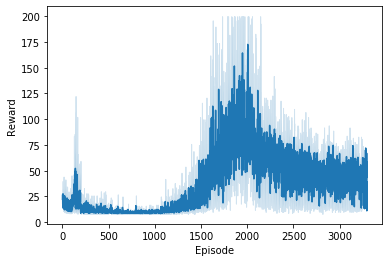

In [11]:
plt.figure()
sns.lineplot(x='Episode', y='Reward',data=results)

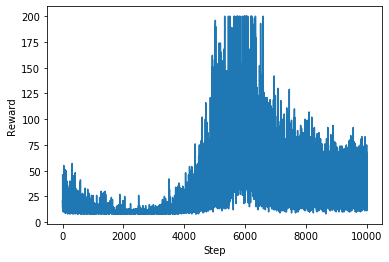

In [12]:
plt.plot(results.Reward)
plt.ylabel('Reward')
plt.xlabel('Step')
plt.show()